<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module6/AdvancedCNN/ScenesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and setup seed

In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed = 59
set_seed(seed)

#Data

##Download

In [3]:
!gdown 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

Downloading...
From (original): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
From (redirected): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639&confirm=t&uuid=f9ed23a6-729b-47fb-8080-f93349375ea6
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:03<00:00, 65.9MB/s]


In [4]:
!unzip img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

##Load data

In [5]:
root_dir = './scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_index: class_name
    for label_index, class_name in enumerate(
        sorted(os.listdir(train_dir))
    )
}

##Split into train, test, val

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
  for label_index, class_name in classes.items():
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      if 'train' in dataset_path:
        X_train.append(image_path)
        y_train.append(label_index)
      else:
        X_test.append(image_path)
        y_test.append(label_index)

In [7]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

##Create custom Pytorch Dataset

In [8]:
class ScenesDataset(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img_path = self.X[idx]
    image = Image.open(img_path)
    label = self.y[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [9]:
def transform(img, img_size = (224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[...,:3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0
  return normalized_img

In [10]:
train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

##Create Dataloader

In [11]:
train_batch_size = 64
test_batch_size = 8

train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_dataloader=  DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#Modeling

##Create Different Block in DenseNet

In [12]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(BottleneckBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv1 = nn.Conv2d(
        in_channels,
        4 * growth_rate,
        kernel_size=1,
        bias=False
    )
    self.bn2 = nn.BatchNorm2d(4 * growth_rate)
    self.conv2 = nn.Conv2d(
        4 * growth_rate,
        growth_rate,
        kernel_size=3,
        padding=1,
        bias=False
    )
    self.relu = nn.ReLU()

  def forward(self, x):
    res = x.clone().detach()
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv1(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = torch.cat((res, x), dim=1)
    return x

In [13]:
class DenseBlock(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate):
    super(DenseBlock, self).__init__()
    layers = []
    for i in range(num_layers):
      layers.append(
          BottleneckBlock(in_channels + i * growth_rate, growth_rate)
      )
    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

##Create Model class

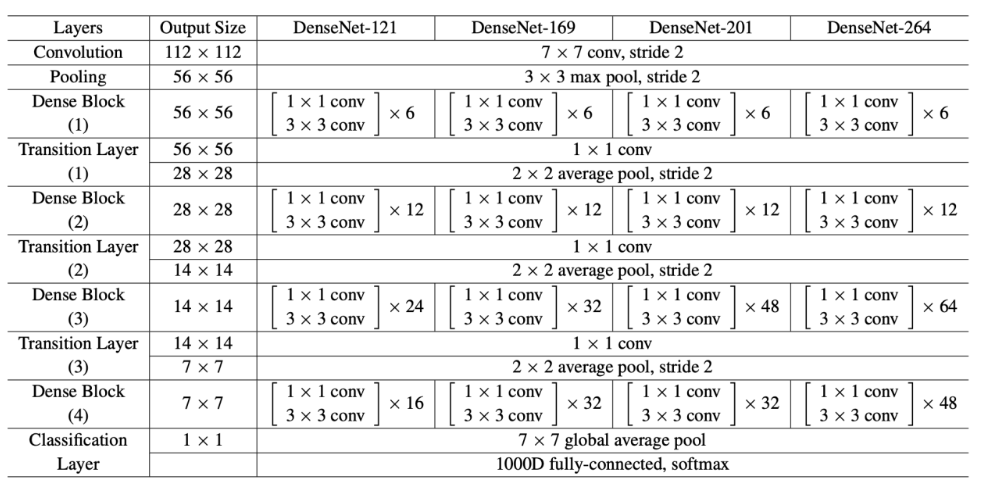

In [14]:
class DenseNet(nn.Module):
  def __init__(self, num_blocks, growth_rate, num_classes):
    super(DenseNet, self).__init__()
    self.conv1 = nn.Conv2d(
        3,
        2*growth_rate,
        kernel_size = 7,
        padding = 3,
        stride = 2,
        bias = False
    )
    self.bn1 = nn.BatchNorm2d(2*growth_rate)
    self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.dense_blocks = nn.ModuleList()
    in_channels = 2*growth_rate
    for i, num_block in enumerate(num_blocks):
      self.dense_blocks.append(DenseBlock(num_block, in_channels, growth_rate))
      in_channels += num_block * growth_rate
      if i != len(num_blocks) - 1:
        out_channels = in_channels//2
        self.dense_blocks.append(
            nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size = 1,
                    bias = False
                ),
                nn.AvgPool2d(kernel_size = 2, stride = 2)
            )
        )
        in_channels = out_channels
    self.bn2 = nn.BatchNorm2d(in_channels)
    self.pool2 = nn.AvgPool2d(kernel_size = 7)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(in_channels, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    for block in self.dense_blocks:
      x = block(x)

    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

##Create Model

In [15]:
n_classes = len(list(classes.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate = 32,
    num_classes = n_classes
).to(device)

In [16]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr = lr
)

##Evaluating Function

In [17]:
def evaluate(model, data_loader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = np.mean(losses)
  accuracy = correct / total

  return loss, accuracy

##Training Function

In [18]:
def fit(model, train_loader, val_loader,
        criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
    batch_train_losses = []
    correct = 0
    total = 0

    model.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print('*'*100)
    print(f'Epoch: {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')
    print('*'*100)

  return train_losses, val_losses, train_accuracies, val_accuracies

##Training

In [19]:
train_losses, val_losses, train_accuracies, val_accuracies = fit(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    device,
    epochs
)

****************************************************************************************************
Epoch: 1/15
Train Loss: 1.0725 | Train Accuracy: 0.5870
Val Loss: 0.7320 | Val Accuracy: 0.7225
****************************************************************************************************
****************************************************************************************************
Epoch: 2/15
Train Loss: 0.7321 | Train Accuracy: 0.7249
Val Loss: 0.6970 | Val Accuracy: 0.7456
****************************************************************************************************
****************************************************************************************************
Epoch: 3/15
Train Loss: 0.5899 | Train Accuracy: 0.7815
Val Loss: 0.6203 | Val Accuracy: 0.7784
****************************************************************************************************
****************************************************************************************************
Epoch

##Visualize

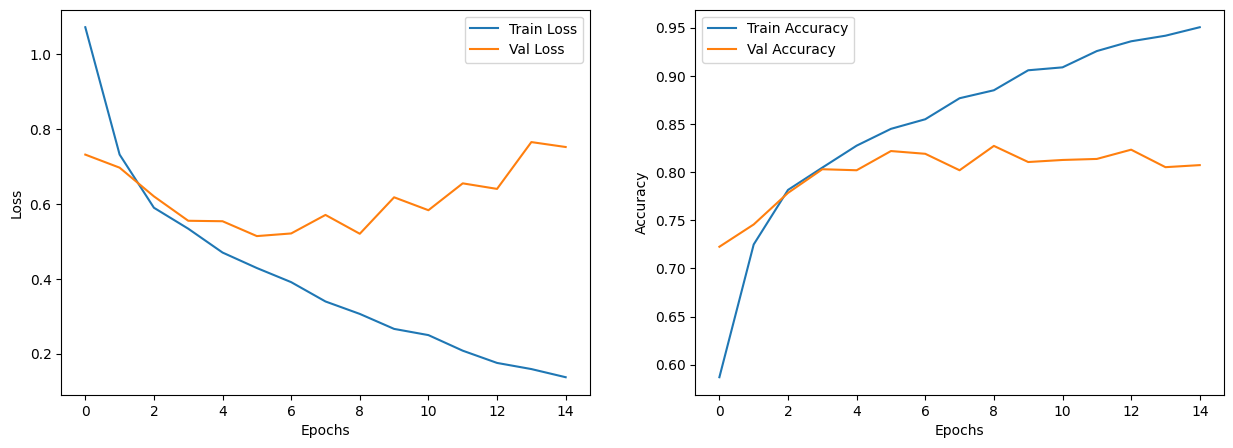

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(train_losses, label = 'Train Loss')
ax[0].plot(val_losses, label = 'Val Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracies, label = 'Train Accuracy')
ax[1].plot(val_accuracies, label = 'Val Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()